In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

# Load WHO Data

In [4]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth


In [5]:
# These countries appear in both the MICS and the WHO datasets
overlaps = [
    'Benin',
    'Cameroon',
    'Cuba',
    'Dominican Republic',
    'El Salvador',
    'Guyana',
    'Kazakhstan',
    'Kyrgyzstan',
    'Malawi',
    'Mali',
    'Mexico',
    'Nepal',
    'Paraguay',
    'Sudan',
    'Swaziland',
    'Turkmenistan',
    'Zimbabwe',
]

# some MICS regions are just subsets of a country, so we
# can only analyze the ones that appear in both datasets
partial_matches = {
    'Kenya (Bungoma County)': 'Kenya',
    'Kenya (Kakamega County)': 'Kenya',
    'Kenya (Turkana County)': 'Kenya',
    'Pakistan (Punjab)': 'Pakistan',
    'Pakistan (Sindh)': 'Pakistan',
}

# Some MICS countries have their names written differently
# Thus maps the MICS version as the key to the WHO version
# as the value
overlap_map = {
    'Guinea Bissau': 'Guinea-Bissau',
    'Sao Tome and Principe': 'Sao Tome & Principe',
}

all_mics_overlaps = list(overlap_map.keys()) + list(partial_matches.keys()) + overlaps

# Load MICS Survey data

In [6]:
childrens_surveys = dict()

for f in Path("../data/interim/MICS").iterdir():
    if f.name.startswith('.'):
        continue
    elif not f.is_dir():
        continue
    childrens_surveys[f.stem] = pd.read_csv(f/'ch.csv', index_col=0)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14,21,30,32,35,37,45,57,77,79,82,98,101,103,104,106,145,149,153,174,175,176,177,178,180,181,182,183,184,185,186,187,188,189,199,200,201,203,204,205,206,208,219,220,221,222,223,224,225,226,227,228,230,231,232,238,239,240,241,246,249,266,267,268,270,281,291,300) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (245,253,254,255,265,289,345) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,78,81,

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,78,81,145,152,174,177,179,181,185,187,203,205,206,207,219,226,230,232,286,314,316) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25,103,104,105,106,107,108,176,178,183,197,198,199,202,213,214,217,229,231,233,235,240,251,253,279) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,19,101,102,103,170,181,193,200,264,290) have mixed types. Specify dtype option on import or set lo

### Upsample surveys based on child weights to get representative child counts

In [10]:
childrens_surveys_upsampled = dict()
for country, df in childrens_surveys.items():
    rng = np.random.RandomState(12345)
    
    w_col = 'chweight' if 'chweight' in df.columns else 'CHWEIGHT'
    
    smpl = rng.choice(df.index, 100000, p=df[w_col] / df[w_col].sum())
    childrens_surveys_upsampled[country] = df.loc[smpl, :]

(100000, 317)
(100000, 302)
(100000, 371)
(100000, 300)
(100000, 303)
(100000, 267)
(100000, 294)
(100000, 344)
(100000, 296)
(100000, 337)
(100000, 276)
(100000, 228)
(100000, 324)
(100000, 317)
(100000, 347)
(100000, 345)
(100000, 290)
(100000, 297)
(100000, 278)
(100000, 317)
(100000, 269)
(100000, 409)
(100000, 316)
(100000, 287)
(100000, 305)
(100000, 277)
(100000, 279)
(100000, 374)
(100000, 362)


In [11]:
relevant_vars = [
    # When conducted
    'UF8Y',
    
    # Where conducted (urban/rural)
    'HH6',
    'HH7',
    
    # Child Age
    'AG2',
    'CAGE',
    'AG1Y',
]

In [12]:
subsetted_dfs = []
for c in all_mics_overlaps:
    df = childrens_surveys_upsampled[c]
    im_vars = [c for c in df.columns if c.startswith('IM')]
    
    df['country'] = c
    subsetted_dfs.append(df[['country'] + im_vars + relevant_vars].copy())

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
all_mics_children_data = pd.concat(subsetted_dfs)

In [14]:
subsetted_dfs = []
for c in all_mics_overlaps:
    df = childrens_surveys[c]
    im_vars = [c for c in df.columns if c.startswith('IM')]
    
    df['country'] = c
    subsetted_dfs.append(df[['country'] + im_vars + relevant_vars].copy())

raw_mics_children_data = pd.concat(subsetted_dfs)

In [15]:
# nepal is in nepalese years...
all_mics_children_data.replace({'UF8Y': {2070.: 2013., 2071.: 2014.}}, inplace=True)
raw_mics_children_data.replace({'UF8Y': {2070.: 2013., 2071.: 2014.}}, inplace=True)

In [16]:
# just include surveys done in at least 2014
min_year = all_mics_children_data.groupby('country').UF8Y.min()
to_include = min_year[min_year >= 2014].index.tolist()

mics_children_data_who_countries = all_mics_children_data[all_mics_children_data.country.isin(to_include)]
raw_mics_children_data_who_countries = raw_mics_children_data[raw_mics_children_data.country.isin(to_include)]

print(mics_children_data_who_countries.shape)
mics_children_data_who_countries.dropna(how='all', axis=1, inplace=True)
raw_mics_children_data_who_countries = raw_mics_children_data_who_countries[mics_children_data_who_countries.columns]
print(mics_children_data_who_countries.shape)

(1900000, 359)


/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(1900000, 356)


In [17]:
country_year_map = mics_children_data_who_countries.groupby('country').UF8Y.max().to_dict()

mics_children_data_who_countries['survey_year'] = mics_children_data_who_countries.country.replace(country_year_map)
raw_mics_children_data_who_countries['survey_year'] = \
    raw_mics_children_data_who_countries.country.replace(country_year_map)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
from collections import namedtuple

Vax = namedtuple('Vax',
                 ['name',           # Group name
                  'doses_dict',     # map standard WHO dose names to year columns
                  'ever_col',       # yes/no for vax ever given 
                  'ever_col_year']) # year for vax ever given

vaxes = [
    Vax(name='BCG',
        doses_dict={'BCG': ['IM3BY']},
        ever_col=['IM7'],
        ever_col_year=[]),
    
    # DTP or Penta
    Vax(name='DTP',
        doses_dict={'DTP1': ['IM3D1Y', 'IM3PV1Y'],
                    'DTP2': ['IM3D2Y', 'IM3PV2Y'],
                    'DTP3': ['IM3D3Y', 'IM3PV3Y'],
                    'DTP4': ['IM3D4Y', 'IM3PV4Y']},
        ever_col=['IM17', 'IM17A', 'IM11', 'IM10A', 'IM11A'],
        ever_col_year=[]),
    
    Vax(name='Measles',
        doses_dict={'MCV1': ['IM3M1Y'],
                    'MCV2': ['IM3M2Y']},
        ever_col=['IM16'],
        ever_col_year=['IM3MY']),
    
# polio
# flu/Hib
# hepb
# pneumo / PCV
]

In [20]:
# Harmonize "ever" questions:
ever_harmonize_map = {
    # yes
    'First two weeks': 1.0,
    'First eight weeks': 1.0,
    'Dans les 2 premières semaines': 1.0,
    'Later': 1.0,
    'Plus tard': 1.0,
    'Sim': 1.0,
    'Si': 1.0,
    'Sí': 1.0,
    'Oui': 1.0,
    'Yes': 1.0,
    '1.0': 1.0,
    '2.0': 1.0,
    '3.0': 1.0,
    '4.0': 1.0,
    '5.0': 1.0,
    '6.0': 1.0,
     2.0: 1.0,
     3.0: 1.0,
     4.0: 1.0,
     '2009.0': 1.0,
     '2010.0': 1.0,
     '2011.0': 1.0,
     '2012.0': 1.0,
     '2013.0': 1.0,
     '2014.0': 1.0,
     '2015.0': 1.0,
     '2016.0': 1.0,
     2013.0: 1.0,
     2014.0: 1.0,
     2015.0: 1.0,
     2016.0: 1.0,  
    'Dans carte de vaccination': 1.0,
    'Déclaration de la mère': 1.0,
    'Madre reportada': 1.0,
    'Reporte de la madre': 1.0,
    'Réponse de la mère': 1.0,
    'Marcada en la tarjeta': 1.0,
    'Marcada sobre la tarjeta': 1.0,
    'Marked on card': 1.0,
    'Marqué sur le carnet': 1.0,
    'Mother reported': 1.0,
    
    # no
    'Non': 0.0,
    'NÃ£o': 0.0,
    'No': 0.0,
    'No aplicada': 0.0,
    'No vacunado': 0.0,
    'Pas reçue/pas vue dans le carnet': 0.0,
    
    # don't know
    'DK': np.nan,
    'Manquant': np.nan,
    'Non déclaré/Pas de réponse': np.nan,
    'Ne sait pas': np.nan,
    'Missing': np.nan,
    'Em falta': np.nan,
    'Incohérent': np.nan,
    'Inconsistent': np.nan,
    'Inconsistente': np.nan,
    'NS': np.nan,
    'NSP': np.nan,
    'No dada': np.nan,
    'No sabe': np.nan,
    'Not given': np.nan,
    'NÃ£o Sabe': np.nan,
    'Omitido': np.nan,
    'Pas donné': np.nan,
}

In [21]:
vaxed_data = mics_children_data_who_countries.copy()
raw_vaxed_data = raw_mics_children_data_who_countries.copy()

In [68]:
vaxed_data.sample(1).T.head(10)

,189
AG1Y,2011
AG2,4
CAGE,54
HH6,Urban
HH7,Ashgabat city
IM1,NaN
IM10,NaN
IM10A,NaN
IM10B,NaN
IM11,NaN


In [69]:
one_yr_old = vaxed_data[vaxed_data.CAGE <= 12]
one_yr_old.head()

KeyboardInterrupt: 

In [22]:
all_cols_added = dict()

for ix, yr in enumerate(list(range(2016, 2013, -1))):
    
    all_cols_added[yr] = [f"denom_{yr}"]
    
    # calc denominator
    vaxed_data[f"denom_{yr}"] = vaxed_data.AG1Y == yr
    raw_vaxed_data[f"denom_{yr}"] = raw_vaxed_data.AG1Y == yr

    for v in vaxes:
        
        cols_added = []
        
        print(v.name)
        
        # track individual doses
        for dose_name, dose_cols in v.doses_dict.items():
            print(dose_name)
            
            new_col = f"{dose_name}_{yr}"
            vaxed_data[new_col] = (vaxed_data[dose_cols] == yr).any(axis=1) & vaxed_data[f"denom_{yr}"]
            raw_vaxed_data[new_col] = (raw_vaxed_data[dose_cols] == yr).any(axis=1) & raw_vaxed_data[f"denom_{yr}"]
            
            cols_added.append(new_col)
        
        # track ever based on ever_col or individual doses
        new_col = f"{v.name}_any_dose_{yr}"
        
        vaxed_data[new_col] = (((vaxed_data[cols_added] == 1.0).any(axis=1) | 
                                (vaxed_data[v.ever_col_year] == yr).any(axis=1) | 
                                (vaxed_data[v.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1)) &
                               vaxed_data[f"denom_{yr}"])
        
        raw_vaxed_data[new_col] = (((raw_vaxed_data[cols_added] == 1.0).any(axis=1) | 
                        (raw_vaxed_data[v.ever_col_year] == yr).any(axis=1) | 
                        (raw_vaxed_data[v.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1)) &
                       raw_vaxed_data[f"denom_{yr}"])

        all_cols_added[yr] += cols_added + [new_col]

BCG
BCG
DTP
DTP1
DTP2
DTP3
DTP4
Measles
MCV1
MCV2
BCG
BCG
DTP
DTP1
DTP2
DTP3
DTP4
Measles
MCV1
MCV2
BCG
BCG
DTP
DTP1
DTP2
DTP3
DTP4
Measles
MCV1
MCV2


In [23]:
coverage_dfs = []
for yr in [2014, 2015, 2016]:    
    sampled_data = (vaxed_data.groupby(['country', 'HH7'])[all_cols_added[yr]].sum())

    raw_data = (raw_vaxed_data.groupby(['country', 'HH7'])[all_cols_added[yr]].sum()) 
    
    # calculate coverage
    cov_percentages = sampled_data.divide(sampled_data[f"denom_{yr}"], axis=0)    

    # only show data where we talked to enough kids
    mics_to_compare = cov_percentages.loc[raw_data[f"denom_{yr}"] >= 30, :].reset_index()

    coverage_dfs.append(mics_to_compare)

In [24]:
### Create immunization value counts

In [40]:
who.shape

(178328, 18)

In [42]:
who.head()

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,google_admin_1,google_admin_2,place_id
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who1151,AFG,Afghanistan,EMRO,2016,Pol3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Polio,Pol3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who175898,AFG,Afghanistan,EMRO,2016,HepB3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,HepB,HepB3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who176254,AFG,Afghanistan,EMRO,2016,Hib3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,H. influenzae,Hib3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who176610,AFG,Afghanistan,EMRO,2016,PCV1,NaN,Aab Band,2.0,1176.0,NaN,...,803.109813,Aab Band,afghanistan,1,Pneumococcal,PCV1,2nd_6wks_2mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4


In [44]:
who = pd.read_csv(Path("../data/interim/who_subnational_with_geocodes.csv"), index_col=0)

coverage_by_Admin1 = (who.groupby(['Country Name', 'google_admin_1', 'Vaccine Type'])
                                 [['recalc_numerator', 'Denominator']]
                                    .sum()
                                    .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                    .unstack())

coverage_by_Admin1.reset_index(inplace=True)
coverage_by_Admin1.head()

Vaccine Type,Country Name,google_admin_1,BCG,DTP1,DTP2,DTP3,DTP4,HepB1,HepB2,HepB3,...,Pol2,Pol3,RCV1,RCV2,Rota1,RotaC,TT2plus,VAD1,Varicella,YFV
0,Afghanistan,Badakhshan,0.700415,0.775380,NaN,0.655052,NaN,NaN,NaN,0.655052,...,NaN,0.655052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Badghis,1.106186,1.106665,NaN,0.961973,NaN,NaN,NaN,0.961973,...,NaN,0.961973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,Baghlan,0.779235,0.807103,NaN,0.712329,NaN,NaN,NaN,0.712329,...,NaN,0.712329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,Balkh,1.005774,1.014727,NaN,0.880062,NaN,NaN,NaN,0.880062,...,NaN,0.880062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Bamiyan,0.369055,0.447983,NaN,0.410001,NaN,NaN,NaN,0.410001,...,NaN,0.410001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Afghanistan,Daykundi,0.744495,0.865730,NaN,0.750302,NaN,NaN,NaN,0.750302,...,NaN,0.750302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,Farah,0.795692,0.834663,NaN,0.712655,NaN,NaN,NaN,0.712655,...,NaN,0.712655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Afghanistan,Faryab,0.845387,0.934138,NaN,0.790780,NaN,NaN,NaN,0.790780,...,NaN,0.790780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Afghanistan,Ghazni,0.747219,0.806401,NaN,0.713288,NaN,NaN,NaN,0.713288,...,NaN,0.713288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Afghanistan,Ghor,0.773348,0.882792,NaN,0.686497,NaN,NaN,NaN,0.686497,...,NaN,0.686497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Geocode from `geocodes.json`

In [27]:
with open(Path("../data/interim/MICS/geocodes.json"), 'r') as f:
    lookups = json.load(f)

{'Benin': {'Alibori': {'_meta': {'key': ['Benin', 'Alibori'],
    'search_string': 'Alibori, Benin'},
   'results': [{'address_components': [{'long_name': 'Alibori',
       'short_name': 'Alibori',
       'types': ['administrative_area_level_1', 'political']},
      {'long_name': 'Benin',
       'short_name': 'BJ',
       'types': ['country', 'political']}],
     'formatted_address': 'Alibori, Benin',
     'geometry': {'bounds': {'northeast': {'lat': 12.4183461,
        'lng': 3.8480219},
       'southwest': {'lat': 10.5044699, 'lng': 2.019249}},
      'location': {'lat': 10.9681093, 'lng': 2.7779813},
      'location_type': 'APPROXIMATE',
      'viewport': {'northeast': {'lat': 12.4183461, 'lng': 3.8480219},
       'southwest': {'lat': 10.5044699, 'lng': 2.019249}}},
     'place_id': 'ChIJLXXwGRGlzRERAmxr5d0Wc5k',
     'types': ['administrative_area_level_1', 'political']}],
   'status': 'OK'},
  'Atacora': {'_meta': {'key': ['Benin', 'Atacora'],
    'search_string': 'Atacora, Benin'}

In [45]:
def extract_canonical_location_info(item):
    place_id, google_admin_1, google_admin_2 = None, None, None
    
    if item['results']:
        place_id = item['results'][0]['place_id']
        
        for ac in item['results'][0]['address_components']:
            if 'administrative_area_level_1' in ac['types']:
                google_admin_1 = unidecode(ac['long_name'])
            elif 'administrative_area_level_2' in ac['types']:
                google_admin_2 = unidecode(ac['long_name'])
    
    return {'google_admin_1': google_admin_1,
            'google_admin_2': google_admin_2,
            'place_id': place_id}


In [47]:
from unidecode import unidecode

In [50]:
cov2014 = coverage_dfs[-3]

reses = []
for ix, item in cov2014.iterrows():
    
    reses.append(extract_canonical_location_info(lookups[item.country][item.HH7]))


cov2014['google_admin_1'] = pd.DataFrame(reses).google_admin_1
cov2014.head()

,country,HH7,denom_2014,BCG_2014,BCG_any_dose_2014,DTP1_2014,DTP2_2014,DTP3_2014,DTP4_2014,DTP_any_dose_2014,MCV1_2014,MCV2_2014,Measles_any_dose_2014,google_admin_1
0,Benin,Alibori,1.0,0.0,0.093371,0.0,0.0,0.0,0.0,0.070028,0.0,0.0,0.000000,Alibori
1,Benin,Atacora,1.0,0.0,0.145108,0.0,0.0,0.0,0.0,0.130182,0.0,0.0,0.000000,Atakora Department
2,Benin,Atlantique,1.0,0.0,0.063137,0.0,0.0,0.0,0.0,0.043711,0.0,0.0,0.000000,Atlantique Department
3,Benin,Borgou,1.0,0.0,0.129271,0.0,0.0,0.0,0.0,0.129271,0.0,0.0,0.055809,Borgou
4,Benin,Collines,1.0,0.0,0.091442,0.0,0.0,0.0,0.0,0.064478,0.0,0.0,0.000000,Collines Department


In [57]:
who_and_mics_by_admin1 = cov2014.merge(coverage_by_Admin1,
                              left_on=['country', 'google_admin_1'],
                              right_on=['Country Name', 'google_admin_1'],
                              how='inner')

In [58]:
who_and_mics_by_admin1.head()

,country,HH7,denom_2014,BCG_2014,BCG_any_dose_2014,DTP1_2014,DTP2_2014,DTP3_2014,DTP4_2014,DTP_any_dose_2014,...,Pol2,Pol3,RCV1,RCV2,Rota1,RotaC,TT2plus,VAD1,Varicella,YFV
0,Benin,Alibori,1.0,0.0,0.093371,0.0,0.0,0.0,0.0,0.070028,...,NaN,1.047539,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1.009117
1,Benin,Atacora,1.0,0.0,0.145108,0.0,0.0,0.0,0.0,0.130182,...,NaN,1.043718,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.991572
2,Benin,Atlantique,1.0,0.0,0.063137,0.0,0.0,0.0,0.0,0.043711,...,NaN,1.007380,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.964607
3,Benin,Borgou,1.0,0.0,0.129271,0.0,0.0,0.0,0.0,0.129271,...,NaN,1.059147,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1.021724
4,Benin,Collines,1.0,0.0,0.091442,0.0,0.0,0.0,0.0,0.064478,...,NaN,1.000936,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.923000


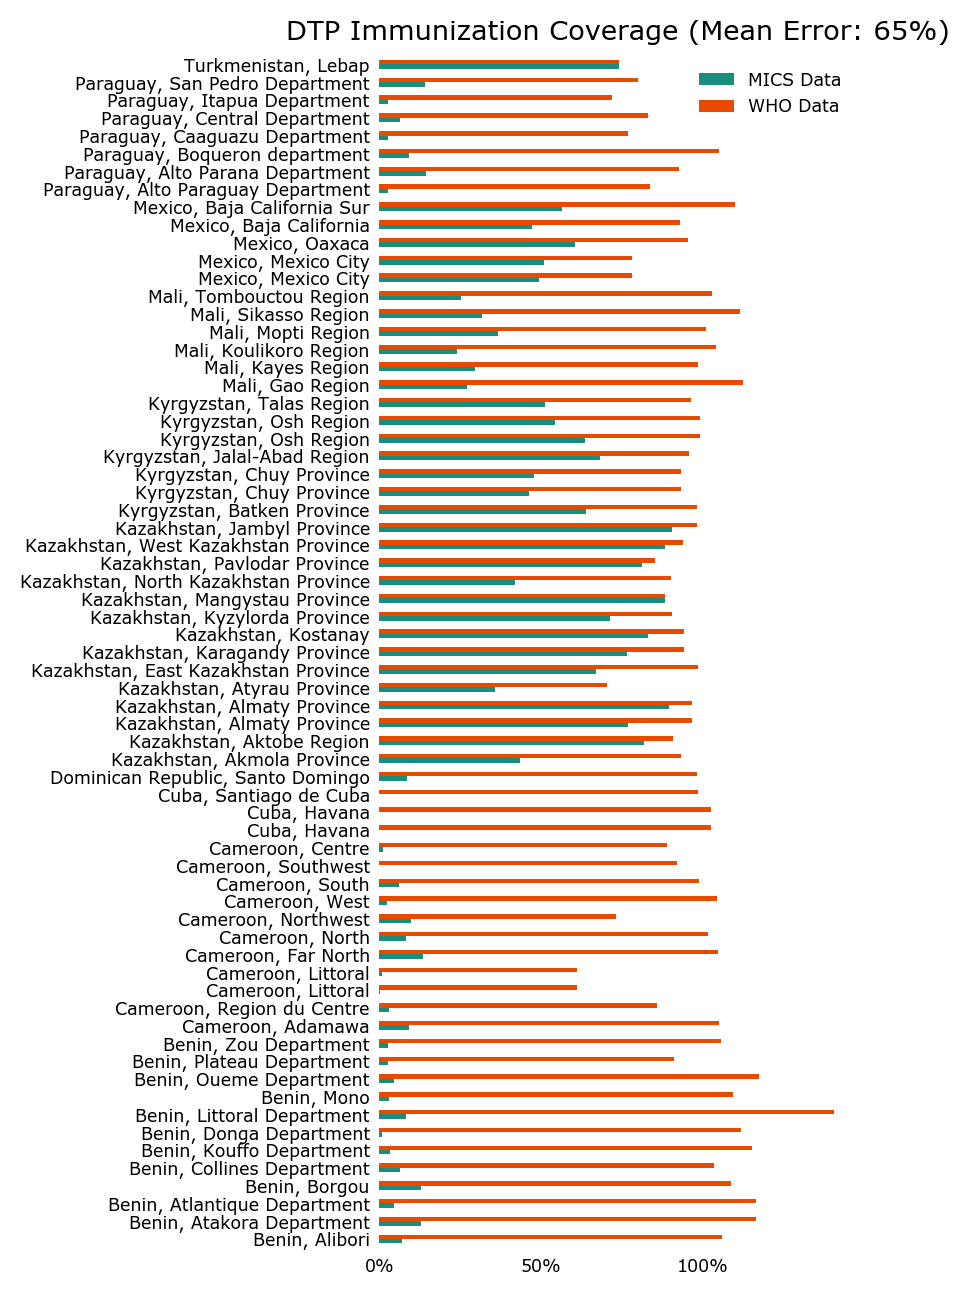

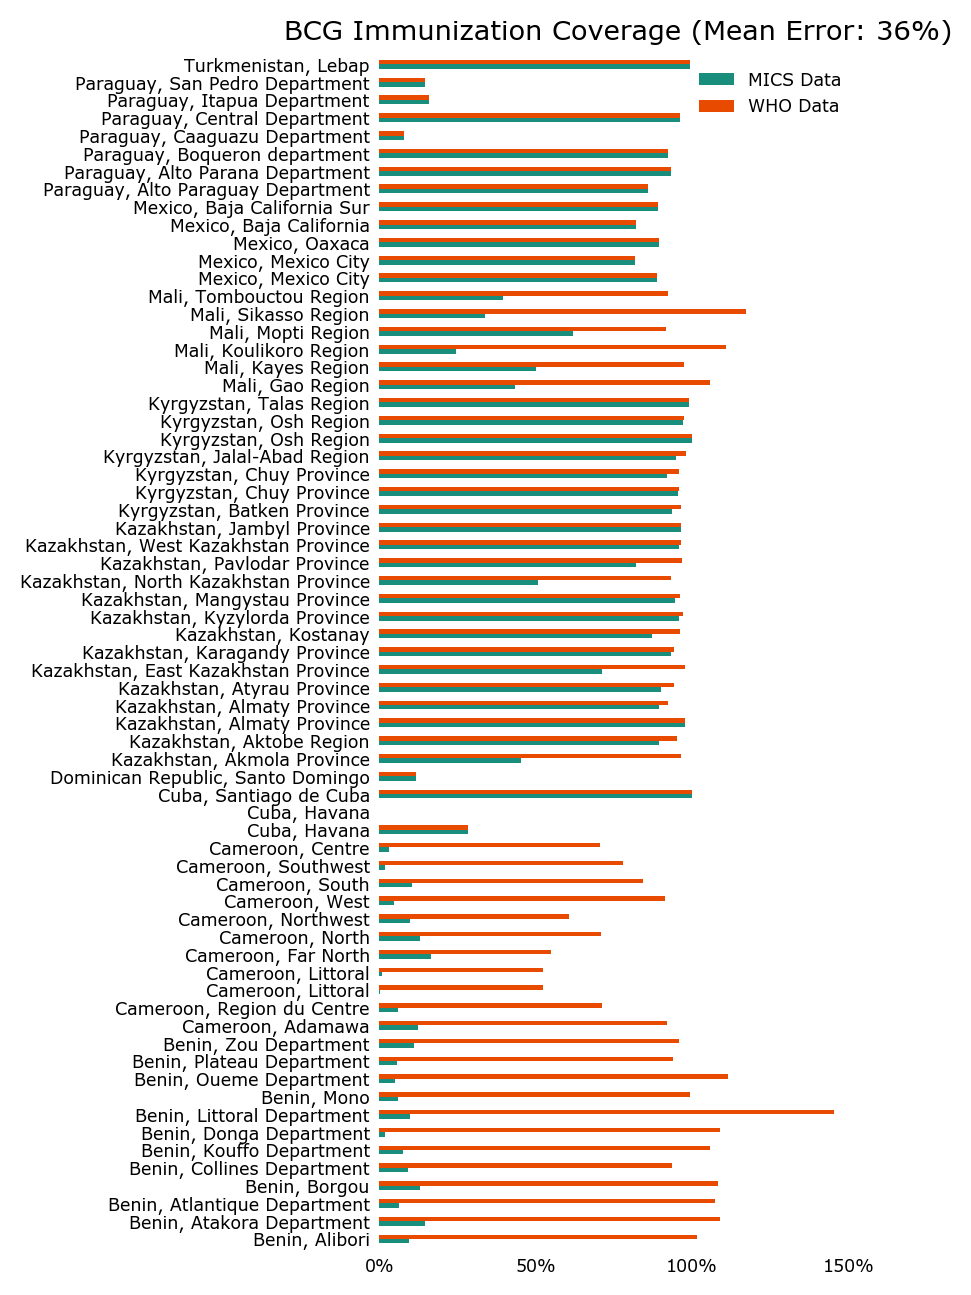

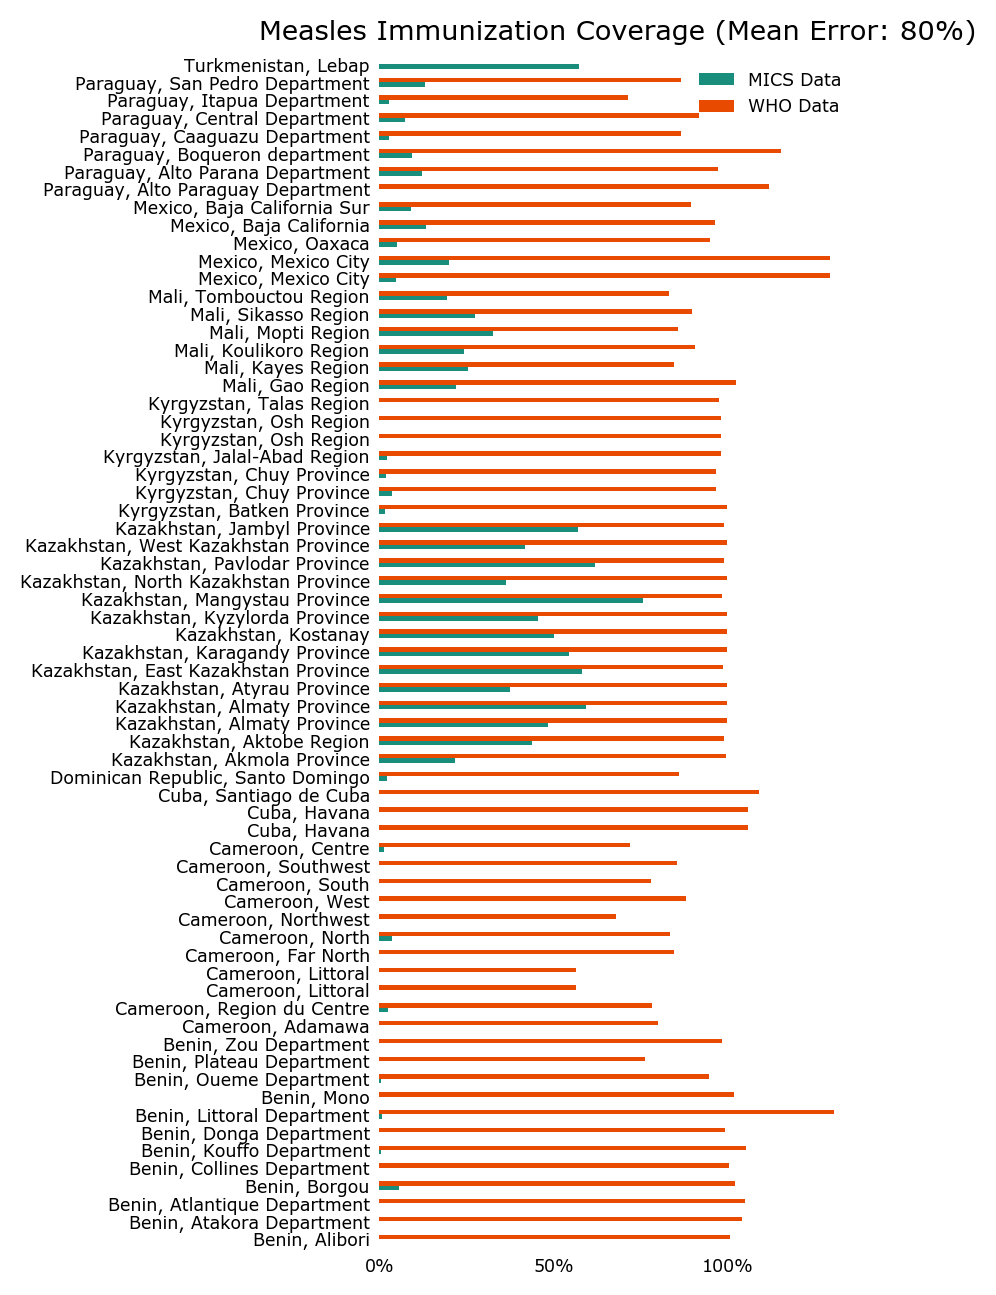

In [63]:
plot_together = [
    ('DTP', 'DTP_any_dose', "DTP Immunization Coverage"),
    ('BCG', 'BCG_any_dose', "BCG Immunization Coverage"),
    ('MCV', 'Measles_any_dose', "Measles Immunization Coverage"),
]


for who_prefix, mics_prefix, title in plot_together:
    to_plot = pd.DataFrame({
        'WHO Data': who_and_mics_by_admin1[[c for c in who_and_mics_by_admin1.columns if c.startswith(who_prefix)]].max(axis=1).values,
        'MICS Data': who_and_mics_by_admin1[[c for c in who_and_mics_by_admin1.columns if c.startswith(mics_prefix)]].max(axis=1).values,
        },
        index = (who_and_mics_by_admin1.country + ", " + who_and_mics_by_admin1.google_admin_1).values
    )
    
    with styled_fig_ax(size='custom', font_size=8, x_formatter=pct_func_formatter(), zero_lines=False,
                       other_rc_params={'figure.figsize': (3, 6.5)}) as ax:
        to_plot.plot.barh(ax=ax)
        av_err = to_plot.diff(axis=1).abs().mean().values[1]
        ax.set_title(title + " (Mean Error: {:.0f}%)".format(av_err*100))

    

In [307]:
# from unidecode import unidecode

# def clean_geo_names(x):
#     x = unidecode(x.strip().upper())
#     x = x.replace("-", " ")
#     return x

In [372]:
# yr=2014
# df=coverage_dfs[0]

# subset_who = coverage_by_Admin1[coverage_by_Admin1['Country Name'].isin(df.country.unique())]
# subset_who['Admin1'] = subset_who['Admin1'].apply(clean_geo_names)


# subset_who.columns = [f"{c}_{yr}" for c in subset_who.columns]
# subset_who.rename(columns={f'Country Name_{yr}': 'country', f'Admin1_{yr}': 'HH7'}, inplace=True)


# df.HH7 = df.HH7.apply(clean_geo_names)

# shared_regions = np.intersect1d(df.HH7.unique(), subset_who.HH7.unique())

# df = df.sort_values(['country', 'HH7'])[df.HH7.isin(shared_regions)]
# subset_who = subset_who[subset_who.HH7.isin(shared_regions)].sort_values(['country', 'HH7'])

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


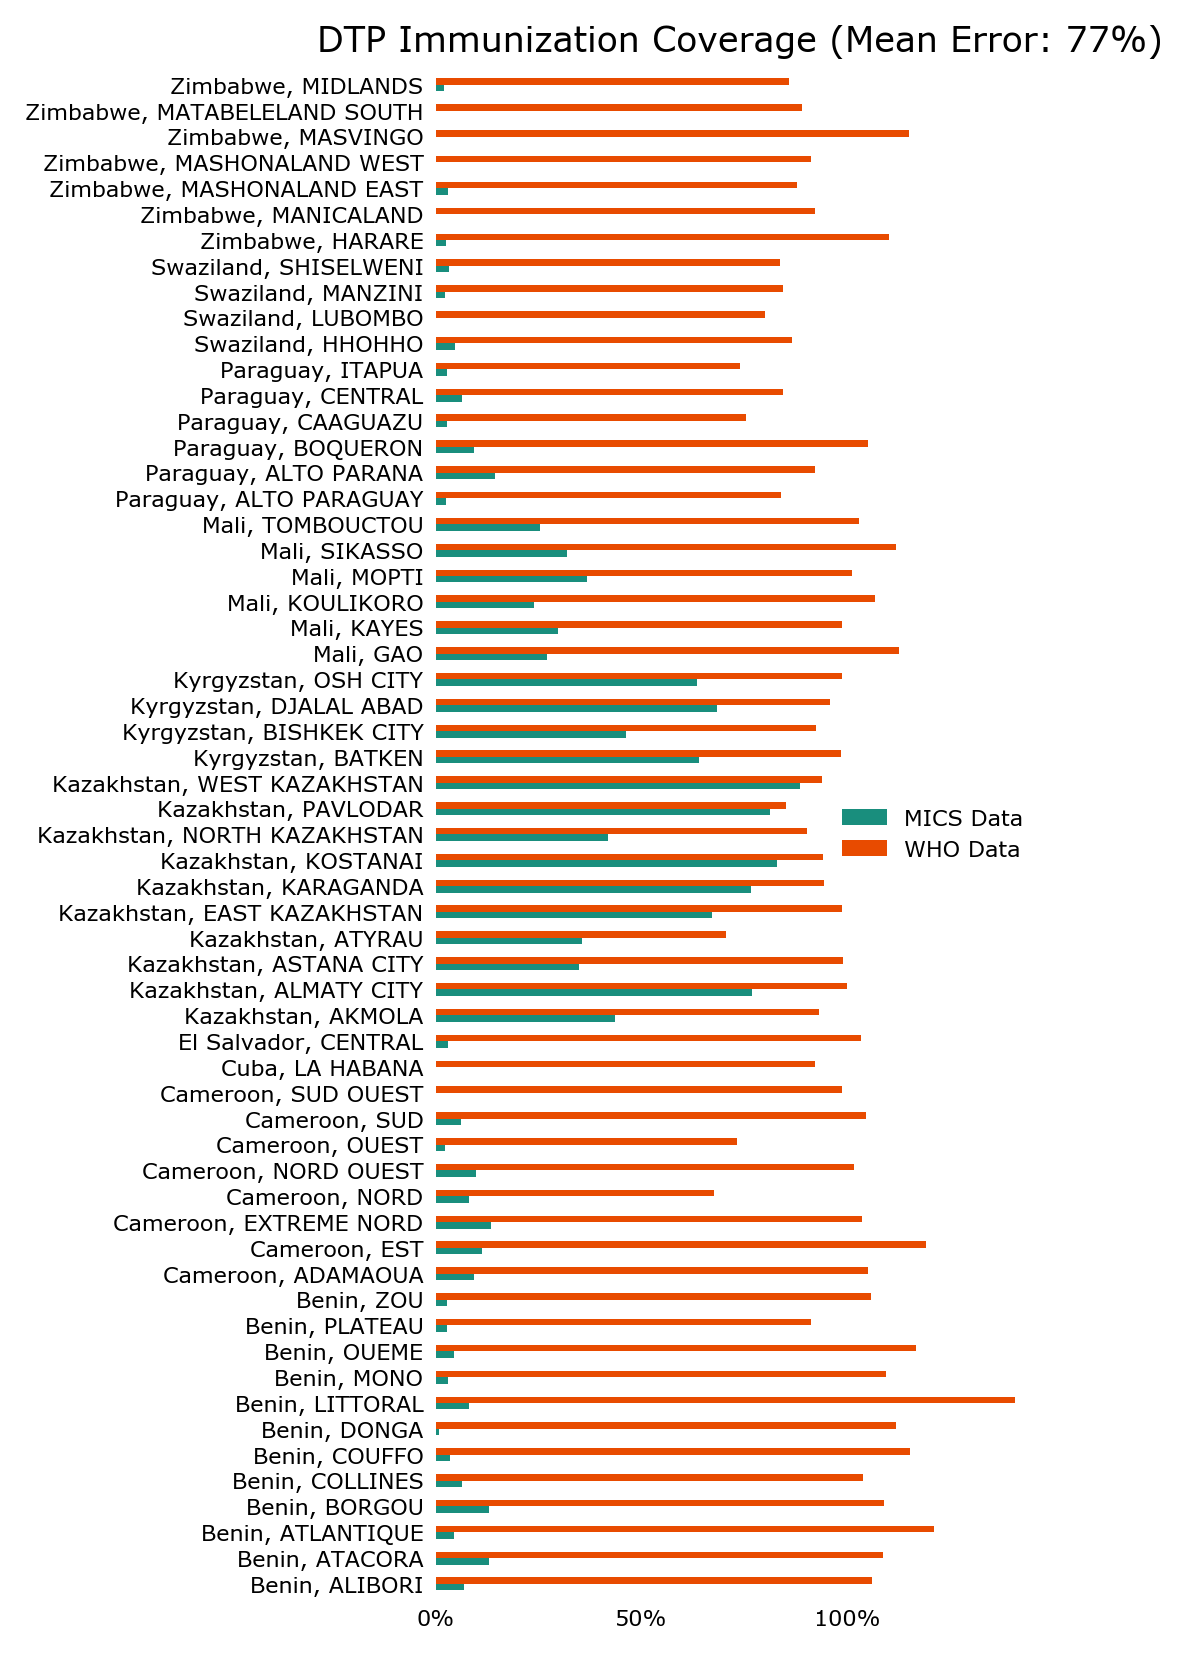

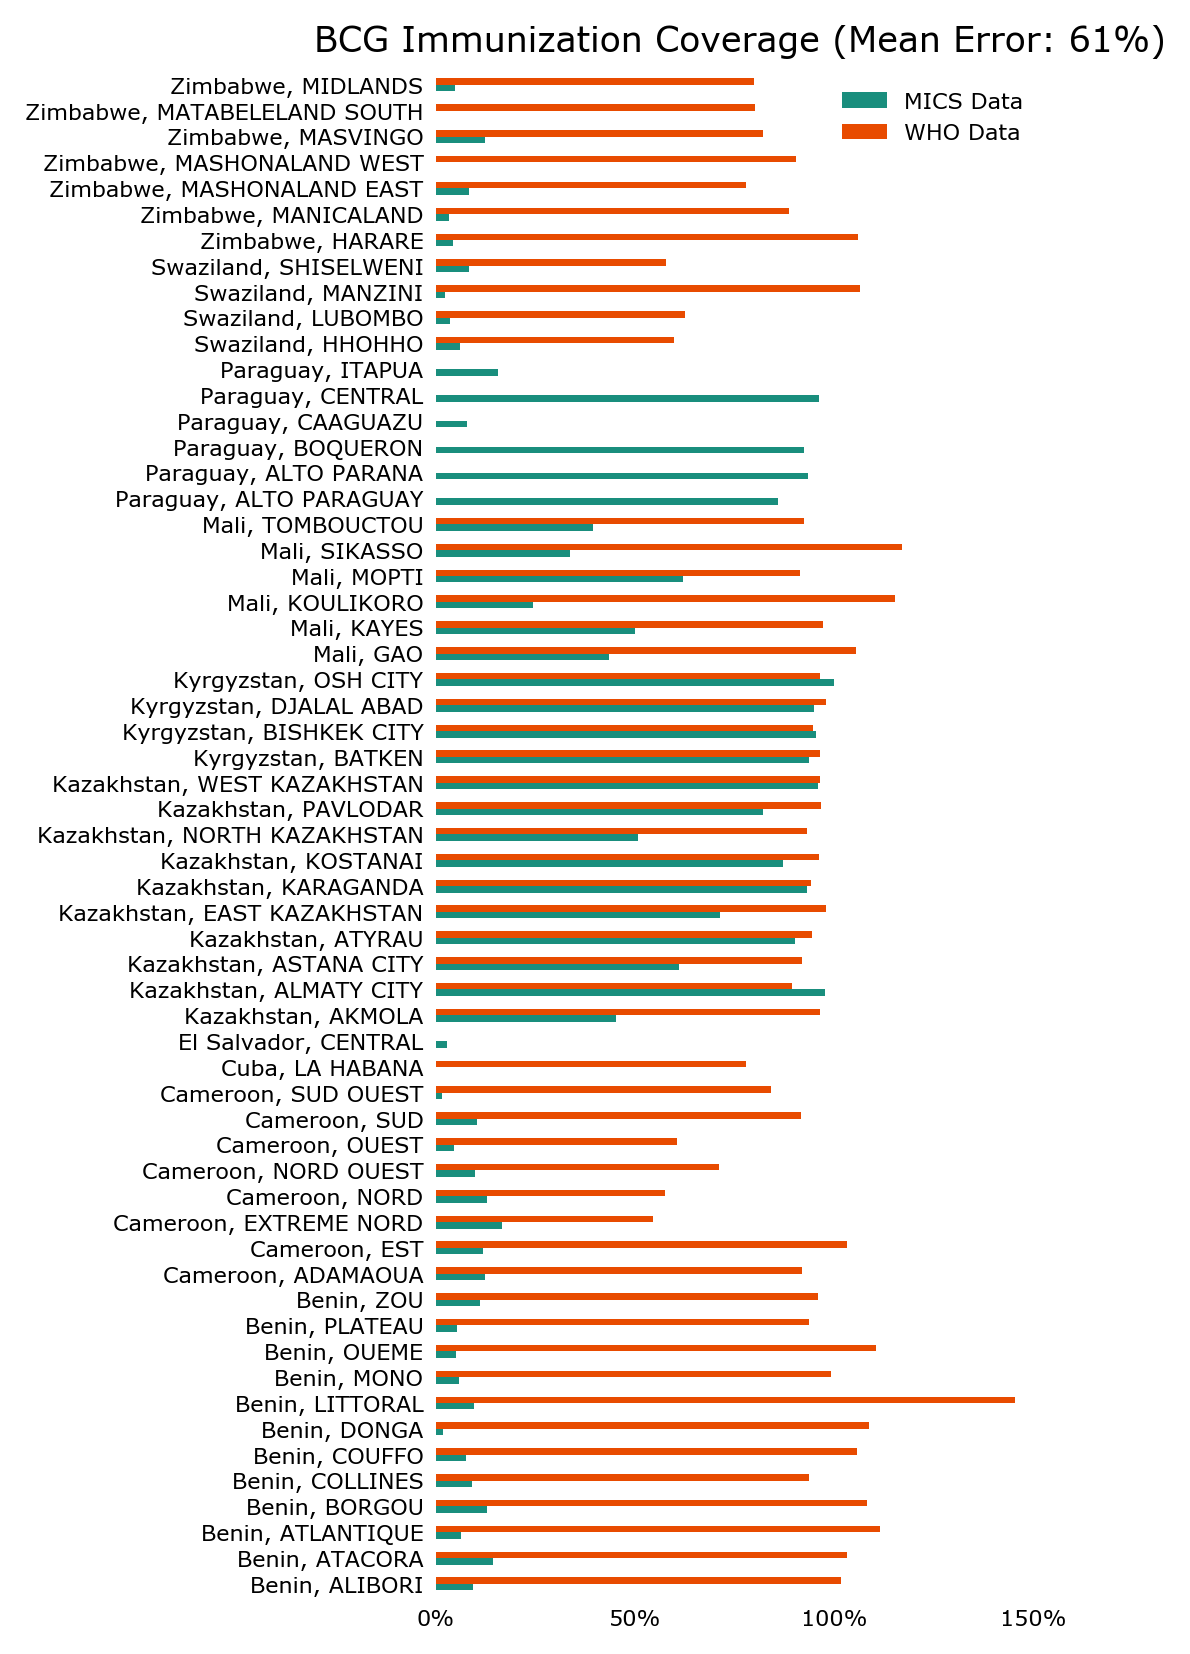

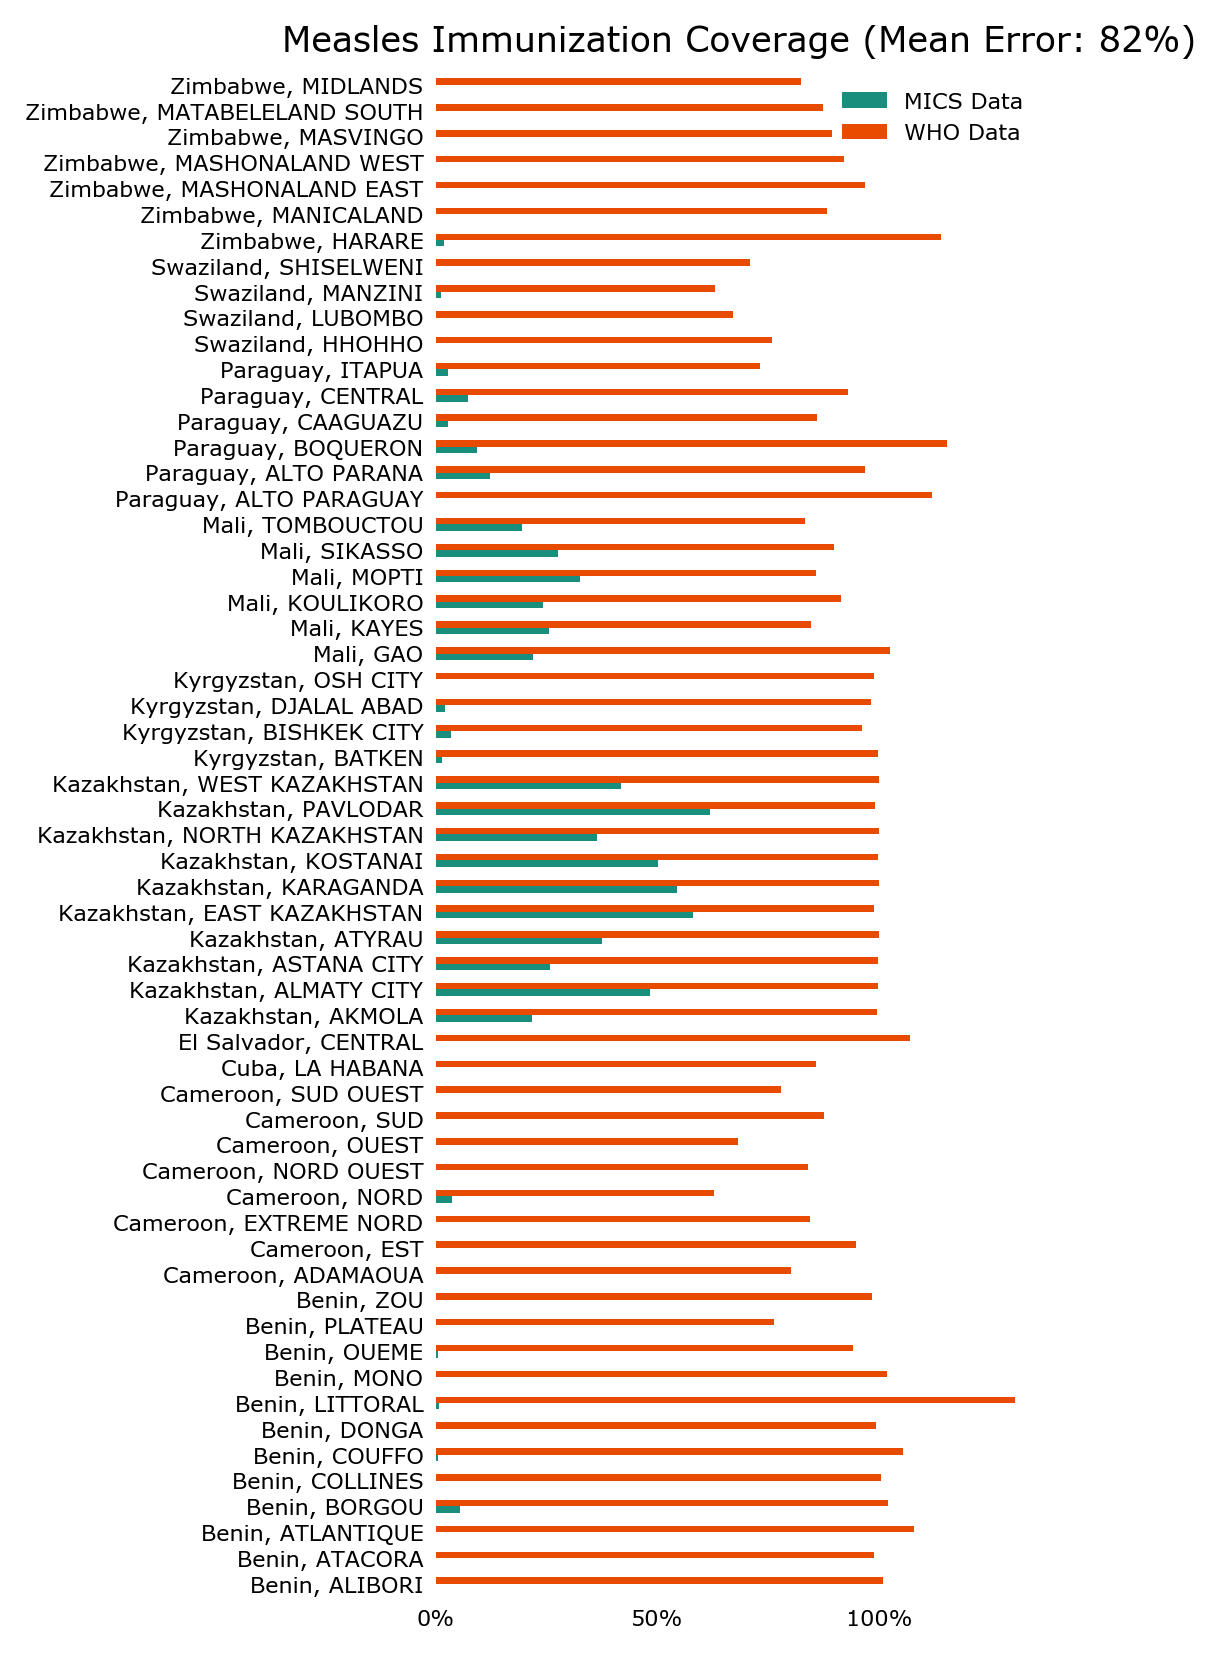

In [334]:
df

,country,HH7,denom_2015,BCG_2015,BCG_any_dose_2015,DTP1_2015,DTP2_2015,DTP3_2015,DTP4_2015,DTP_any_dose_2015,MCV1_2015,MCV2_2015,Measles_any_dose_2015
0,Kazakhstan,AKMOLA,1.0,0.000000,0.453039,0.000000,0.0,0.0,0.0,0.308011,0.0,0.0,0.070442
2,Kazakhstan,ALMATY CITY,1.0,0.000000,0.945819,0.000000,0.0,0.0,0.0,0.441696,0.0,0.0,0.010601
4,Kazakhstan,ASTANA CITY,1.0,0.000000,0.428981,0.000000,0.0,0.0,0.0,0.136298,0.0,0.0,0.022956
5,Kazakhstan,ATYRAU,1.0,0.000000,0.745917,0.000000,0.0,0.0,0.0,0.185118,0.0,0.0,0.105263
6,Kazakhstan,EAST KAZAKHSTAN,1.0,0.000000,0.907463,0.000000,0.0,0.0,0.0,0.608955,0.0,0.0,0.253731
7,Kazakhstan,KARAGANDA,1.0,0.078167,0.730458,0.000000,0.0,0.0,0.0,0.438005,0.0,0.0,0.025606
8,Kazakhstan,KOSTANAI,1.0,0.070423,0.907445,0.000000,0.0,0.0,0.0,0.484909,0.0,0.0,0.086519
11,Kazakhstan,PAVLODAR,1.0,0.000000,0.851852,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,0.328042
13,Kazakhstan,WEST KAZAKHSTAN,1.0,0.000000,0.901639,0.000000,0.0,0.0,0.0,0.627422,0.0,0.0,0.023845
15,Mali,GAO,1.0,0.332425,0.520436,0.000000,0.0,0.0,0.0,0.160763,0.0,0.0,0.043597


In [326]:
subset_who

,country,HH7,BCG_2016,DTP1_2016,DTP2_2016,DTP3_2016,DTP4_2016,HepB1_2016,HepB2_2016,HepB3_2016,...,Pol2_2016,Pol3_2016,RCV1_2016,RCV2_2016,Rota1_2016,RotaC_2016,TT2plus_2016,VAD1_2016,Varicella_2016,YFV_2016
1316,Paraguay,ALTO PARANA,NaN,0.920524,NaN,0.852470,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1319,Paraguay,CAAGUAZU,NaN,0.752839,NaN,0.738600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1323,Paraguay,CENTRAL,NaN,0.843272,NaN,0.806035,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1327,Paraguay,ITAPUA,NaN,0.710572,NaN,0.739117,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
